# SBI CMB lensing

In [16]:
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import camb
import numpy as np
import sys
sys.path.append("../CMB_lensing_SBI/")
from cmb_lensing_sbi_pipe import *
import healpy as hp
from pixell import enmap
from pixell import curvedsky as cs
from pixell import enmap,lensing as plensing,curvedsky, utils, enplot
from orphics import io,maps
from falafel import qe
import re
import gc
from scipy.interpolate import interp1d

# some config -------------

# PATHS CHANGED TO WORK ON NIAGARA, NOT NERSC (BUT SHOULD BE SIMILAR)
path_files = '/scratch/r/rbond/jaejoonk/lensing_pipeline_data/'
outdir = '/scratch/r/rbond/jaejoonk/CMB_lensing_maps/'

beam_fwhm = 1.4


# maps config --------------
nside = 1024 
arcmin_res_car = 3# this somehow determines also the resolutionof the CAR maps. can't be too small.
lmax = 2500 #6000? it's quite a lot ~
cmb_lmax = 10000 # unused for now




#### ACT configs -----------
data_maps_fn_pattern = 'sim_cmb_night_%s_%s_%s_3pass_1way_set%s_map.fits'
m = 'night'
a_f = ['pa4_f150','pa5_f090','pa5_f150','pa6_f090','pa6_f150']
qids = ['pa4av4', 'pa5av4', 'pa5bv4', 'pa6av4','pa6bv4'] 
array_dict = {'pa4av4': 'pa4_f150', 'pa5av4': 'pa5_f090', 'pa5bv4': 'pa5_f150','pa6av4': 'pa6_f090', 'pa6bv4': 'pa6_f150'}
gain_dict =  {
             "pa4_f150": 0.9708, "pa4_f220": 1.1119, "pa5_f090": 0.9625,
             "pa5_f150": 0.9961, "pa6_f090": 0.9660, "pa6_f150": 0.9764,
             }

pol_eff = {
            'pa4av4': 0.9584, 'pa5av4': 0.9646, 'pa5bv4': 0.9488,
            'pa6av4': 0.9789, 'pa6bv4': 0.9656
        }


# changed for niagara
global_folder = '/scratch/r/rbond/jaejoonk/lensing_pipeline_data/'
catalog_large = global_folder + 'catalog_large/union_catalog_large_20220316.csv'
catalog_regular = global_folder +'catalog_regular/union_catalog_regular_20220316.csv'
nemomodel_f090 = global_folder+ '/nemomodel_f090/nemomodel_dr6_all_clustersSNR5090down2.fits'
nemomodel_f150 = global_folder+ '/nemomodel_f150/nemomodel_dr6_all_clustersSNR5150down2.fits'
beams_path = global_folder+ '/beams_path/20230902/'
szbeam150 = global_folder+ '/szbeam150/s16_pa2_f150_nohwp_night_beam_tform_jitter.txt'
szbeam90 =  global_folder+ '/szbeam90/s16_pa3_f090_nohwp_night_beam_tform_jitter.txt'
calibration = global_folder+ 'calibration/tf_fit_dr6_%s_%s.dat'
kcoadded_alms=  'kcoadd_data_tszsub_%s_%s.fits'

camb_filename = '../data/cosmo2017_10K_acc3_params.ini'

nsplits = 1
sim_num = 1
data_run = False
model_subtract_tsz = False


# CONFIG COSMOLOGY (CAMB)

In [17]:
# it's really this simple!
pars = camb.read_ini(camb_filename)
results = camb.get_results(pars)

# CMB_unit set to None to exclude ~1e12 factor,
# raw_cl to give me Cl not l(l+1)/2pi Cl
powers = results.get_cmb_power_spectra(pars, CMB_unit=None, raw_cl=True)

# LET'S MAKE TT,EE,BB and KAPPA maps. Let's also lens TT,EE,BB

In [18]:
'''
Let's generate some TT,TE.. using CLASS (it will be useful in the long run).
I don't think it will matter for this test if these are all slightly different..

'''
    
# COMPUTE TT EE BB POWER SPECTRA WITH CAMB ------------------------------------------------------------------------------------------------------------

unlensed_cls = {'tt': powers['unlensed_scalar'][:,0], 'te': powers['unlensed_scalar'][:,3],
                'ee': powers['unlensed_scalar'][:,1], 'bb': powers['unlensed_scalar'][:,2]}

# Get the lensed and unlensed CMB power spectra up to lmax
#lensed_cls = cosmo.lensed_cl(lmax) 
#unlensed_cls = cosmo.raw_cl(lmax) 

lensed_cls = {'tt': powers['lensed_scalar'][:,0], 'te': powers['lensed_scalar'][:,3],
              'ee': powers['lensed_scalar'][:,1], 'bb': powers['lensed_scalar'][:,2],
              'pp': powers['lens_potential'][:,0]}

# Generate TT, EE, EB, BB power spectra from unlensed alms
ps = np.array([[unlensed_cls['tt'], unlensed_cls['te'], 0 * unlensed_cls['te']],
               [unlensed_cls['te'], unlensed_cls['ee'], 0 * unlensed_cls['te']],
               [0 * unlensed_cls['tt'], 0 * unlensed_cls['te'], 0 * unlensed_cls['bb']]])


# Generate random alms (spherical harmonic coefficients) for the power spectra
alms_ = cs.rand_alm(ps, ainfo=None, lmax=lmax, seed=None, dtype=np.complex128, m_major=True, return_ainfo=False)

# Convert alms to Healpix maps
T_map = hp.alm2map(alms_[0], nside=nside)
E_map = hp.alm2map(alms_[1], nside=nside)
B_map = hp.alm2map(alms_[2], nside=nside)

# Compute the power spectra of the maps
T_cl = hp.anafast(T_map)
E_cl = hp.anafast(E_map)
B_cl = hp.anafast(B_map)

# Assuming T_cl, E_cl, B_cl, unlensed_cls, and lmax are defined
ell = np.arange(len(T_cl))


###### compute kappa and lens maps --------------------------------------------------

# Make a noiseless kappa map
ell_ = np.arange(len(lensed_cls['pp']))  # Define ell array for the power spectrum
kappa_cmb = hp.synfast((lensed_cls['pp'] * (ell_ * (ell_ + 1) / 2)**2), nside=nside, lmax=lmax)  # Generate kappa map using the lensing potential power spectrum

# Compute alms from the kappa map

kappa_cmb_alm = hp.map2alm(kappa_cmb,lmax=lmax)  # Convert kappa map to spherical harmonics coefficients (alms)
ell, emm = hp.Alm.getlm(lmax=lmax)  # Get ell and m values for the alms

# Convert kappa alms to phi alms (lensing potential)
phi_cmb_alm = kappa_cmb_alm / (ell * (ell + 1) / 2)  # Calculate the lensing potential alms
phi_cmb_alm[ell==0] = 1e-30
# Define the shape and WCS (World Coordinate System) for the map
shape, wcs = enmap.fullsky_geometry(res=np.deg2rad(arcmin_res_car/60.), proj="car")  # Set map resolution to 1 arcminute

# Generate lensed T, E, and B maps from the alms and lensing potential
maps_ = pixell.lensing.lens_map_curved((3, shape[0], shape[1]), wcs, phi_cmb_alm, alms_, phi_ainfo=None, maplmax=None, dtype=np.float64, spin=[0, 2], output="l", geodesic=True, verbose=False, delta_theta=None)

# Convert the lensed maps to alms
alm_TEB = pixell.curvedsky.map2alm(maps_[0], lmax=lmax, spin=[0, 2])


# Apply beam -----------------
alm_TEB[0] = cs.almxfl(alm_TEB[0], lambda ell: gauss_beam(ell, beam_fwhm))
alm_TEB[1] = cs.almxfl(alm_TEB[1], lambda ell: gauss_beam(ell, beam_fwhm))
alm_TEB[2] = cs.almxfl(alm_TEB[2], lambda ell: gauss_beam(ell, beam_fwhm))

# Compute the power spectra from the beam-applied alms
cl_T_lensed_hp = hp.alm2cl(alm_TEB[0])
cl_E_lensed_hp = hp.alm2cl(alm_TEB[1])
cl_B_lensed_hp = hp.alm2cl(alm_TEB[2])

# Convert the beam-applied alms back to maps
map_T_lensed_hp, map_E_lensed_hp, map_B_lensed_hp = hp.alm2map(alm_TEB, nside=nside, pol=False)

# Calculate the beam function for the given FWHM
tht_fwhm = np.deg2rad(beam_fwhm / 60.)
f_beam = np.exp(-(tht_fwhm**2) * (np.arange(lmax)**2) / (16 * np.log(2.)))


/tmp/ipykernel_123621/34349403.py:55: RuntimeWarning: divide by zero encountered in divide
  phi_cmb_alm = kappa_cmb_alm / (ell * (ell + 1) / 2)  # Calculate the lensing potential alms
/tmp/ipykernel_123621/34349403.py:55: RuntimeWarning: invalid value encountered in divide
  phi_cmb_alm = kappa_cmb_alm / (ell * (ell + 1) / 2)  # Calculate the lensing potential alms


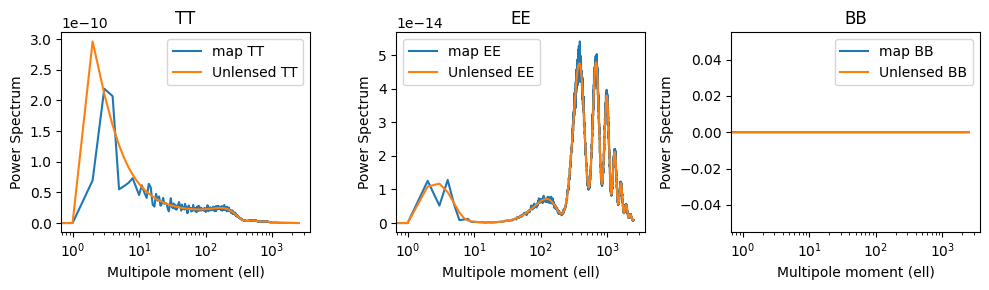

In [19]:
############################################################################################################
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

# Plot TT
axs[0].plot(T_cl[:lmax] * ell[:lmax], label='map TT')
axs[0].plot(unlensed_cls['tt'][:lmax] * ell[:lmax], label='Unlensed TT')
axs[0].set_xscale('log')
axs[0].set_title('TT')
axs[0].set_xlabel('Multipole moment (ell)')
axs[0].set_ylabel('Power Spectrum')
axs[0].legend()

# Plot EE
axs[1].plot(E_cl[:lmax] * ell[:lmax], label='map EE')
axs[1].plot(unlensed_cls['ee'][:lmax] * ell[:lmax], label='Unlensed EE')
axs[1].set_xscale('log')
axs[1].set_title('EE')
axs[1].set_xlabel('Multipole moment (ell)')
axs[1].set_ylabel('Power Spectrum')
axs[1].legend()

# Plot BB
axs[2].plot(B_cl[:lmax] * ell[:lmax], label='map BB')
axs[2].plot(unlensed_cls['bb'][:lmax] * ell[:lmax], label='Unlensed BB')
axs[2].set_xscale('log')
axs[2].set_title('BB')
axs[2].set_xlabel('Multipole moment (ell)')
axs[2].set_ylabel('Power Spectrum')
axs[2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
############################################################################################################

/tmp/ipykernel_123621/2865981119.py:6: RuntimeWarning: divide by zero encountered in divide
  axs[0].plot(ell[:lmax], T_cl[:lmax] / unlensed_cls['tt'][:lmax] , label='Unlensed TT')
/tmp/ipykernel_123621/2865981119.py:7: RuntimeWarning: divide by zero encountered in divide
  axs[0].plot(ell[:lmax], cl_T_lensed_hp[:lmax] / unlensed_cls['tt'][:lmax] , label='Lensed TT')
/tmp/ipykernel_123621/2865981119.py:8: RuntimeWarning: invalid value encountered in divide
  axs[0].plot(ell[:lmax], lensed_cls['tt'][:lmax]*f_beam**2 / unlensed_cls['tt'][:lmax] , label='CAMB Lensed TT')
/tmp/ipykernel_123621/2865981119.py:9: RuntimeWarning: invalid value encountered in divide
  axs[0].plot(ell[:lmax], unlensed_cls['tt'][:lmax] / unlensed_cls['tt'][:lmax] )
/tmp/ipykernel_123621/2865981119.py:17: RuntimeWarning: divide by zero encountered in divide
  axs[1].plot(ell[:lmax], E_cl[:lmax] / unlensed_cls['ee'][:lmax], label='Unlensed EE')
/tmp/ipykernel_123621/2865981119.py:18: RuntimeWarning: invalid value e

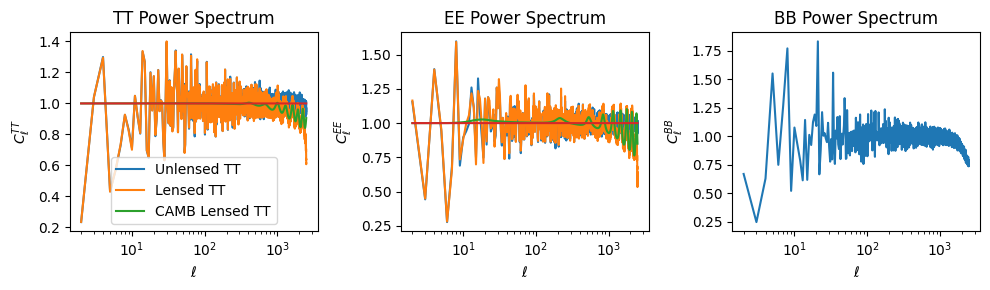

In [20]:
############################################################################################################

fig, axs = plt.subplots( 1,3, figsize=(10, 3))

# TT plot
axs[0].plot(ell[:lmax], T_cl[:lmax] / unlensed_cls['tt'][:lmax] , label='Unlensed TT')
axs[0].plot(ell[:lmax], cl_T_lensed_hp[:lmax] / unlensed_cls['tt'][:lmax] , label='Lensed TT')
axs[0].plot(ell[:lmax], lensed_cls['tt'][:lmax]*f_beam**2 / unlensed_cls['tt'][:lmax] , label='CAMB Lensed TT')
axs[0].plot(ell[:lmax], unlensed_cls['tt'][:lmax] / unlensed_cls['tt'][:lmax] )
axs[0].set_xscale('log')
axs[0].set_title('TT Power Spectrum')
axs[0].set_xlabel(r'$\ell$')
axs[0].set_ylabel(r'$C_\ell^{TT}$')
axs[0].legend()

# EE plot
axs[1].plot(ell[:lmax], E_cl[:lmax] / unlensed_cls['ee'][:lmax], label='Unlensed EE')
axs[1].plot(ell[:lmax], cl_E_lensed_hp[:lmax] / unlensed_cls['ee'][:lmax], label='Lensed EE')
axs[1].plot(ell[:lmax], lensed_cls['ee'][:lmax]*f_beam**2 / unlensed_cls['ee'][:lmax], label='CAMB Lensed EE')
axs[1].plot(ell[:lmax], unlensed_cls['ee'][:lmax] / unlensed_cls['ee'][:lmax], label='Reference')
axs[1].set_xscale('log')
axs[1].set_title('EE Power Spectrum')
axs[1].set_xlabel(r'$\ell$')
axs[1].set_ylabel(r'$C_\ell^{EE}$')


# BB plot
axs[2].plot(ell[:lmax], cl_B_lensed_hp[:lmax] / lensed_cls['bb'][:lmax]/f_beam**2 , label='Lensed BB')
axs[2].set_xscale('log')
axs[2].set_title('BB Power Spectrum')
axs[2].set_xlabel(r'$\ell$')
axs[2].set_ylabel(r'$C_\ell^{BB}$')

# Adjust layout
plt.tight_layout()
plt.show()


############################################################################################################

# Let's add noise and create multiple channels

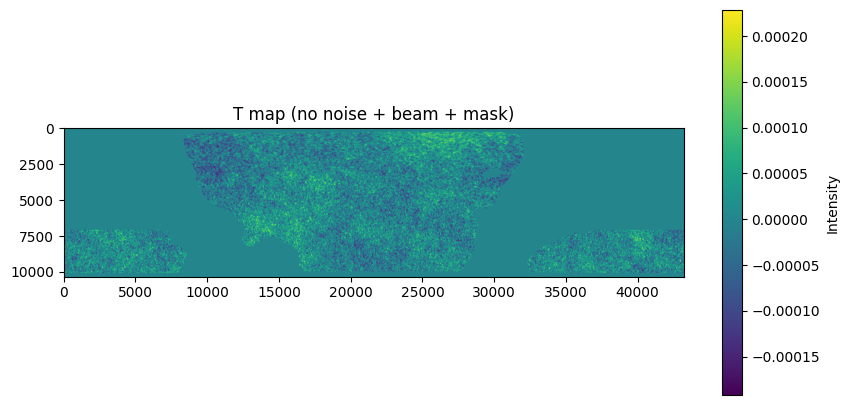

In [5]:
# Define paths to the mask and noise simulation files
mask_path = path_files + "/mask/act_mask_fejer1_20220316_GAL070_rms_70.00_downgrade_None.fits"
noise_path = '/noise_sims_path/noise_sims/'

# Read the mask map
mask = enmap.read_map(mask_path)


# Create an empty map to fill with noise
full_shape, full_wcs = mask.shape, mask.wcs
imap = enmap.empty((3,) + full_shape, full_wcs, dtype=np.float32)

# Convert the alms to a map, convolved with the beam
sigmap_conv = cs.alm2map(alm_TEB, imap)

# Apply the mask to the map (set regions with mask < 0.25 to 0)
sigmap_conv[:, mask < 0.25] = 0

# Handle NaN values in the map (set them to 0)
sigmap_conv[np.isnan(sigmap_conv)] = 0

# Plot the temperature (T) map
plt.figure(figsize=(10, 5))
plt.imshow(np.array(sigmap_conv[0].data))  # Plot the T map
plt.title('T map (no noise + beam + mask)')
plt.colorbar(label='Intensity')
plt.show()

In [6]:


totmap_dict = dict()


for split in range(nsplits):
    for i,af in enumerate(a_f):

        #froot = "/home/s/sievers/kaper/scratch/maps/dr6v4_20230316/" #'/home/s/sievers/kaper/scratch/maps/dr6v3_20211031/'
        #fname = f"{froot}cmb_{m}_{af}_3pass_4way_coadd_ivar.fits" #f"{froot}cmb_{m}_{a}_{f}_8way_coadd_ivar.fits"
        #ivar = enmap.read_map(fname)

        ivar = 10000000.*np.ones((3,)+full_shape)
        seed = int(i)+5
        wn_map = white_noise((3,)+full_shape,full_wcs,seed = seed,div=ivar)
        totmap = (sigmap_conv+wn_map)
        totmap[:,mask<0.25] = 0 
        totmap[np.isnan(totmap)] = 0
        totmap_dict[af] = totmap

        #'''
        
        #? coadd vs split? how to change this?
        enmap.write_map(f"{outdir}sim_cmb_{m}_{af}_{sim_num}_3pass_1way_set{split}_ivar.fits",ivar)
        enmap.write_map(f"{outdir}sim_cmb_{m}_{af}_{sim_num}_3pass_1way_coadd_ivar.fits",ivar)
        enmap.write_map(f"{outdir}sim_cmb_{m}_{af}_{sim_num}_3pass_1way_set{split}_map_srcfree.fits",totmap)
        enmap.write_map(f"{outdir}sim_cmb_{m}_{af}_{sim_num}_3pass_1way_coadd_map_srcfree.fits",totmap)
        #'''

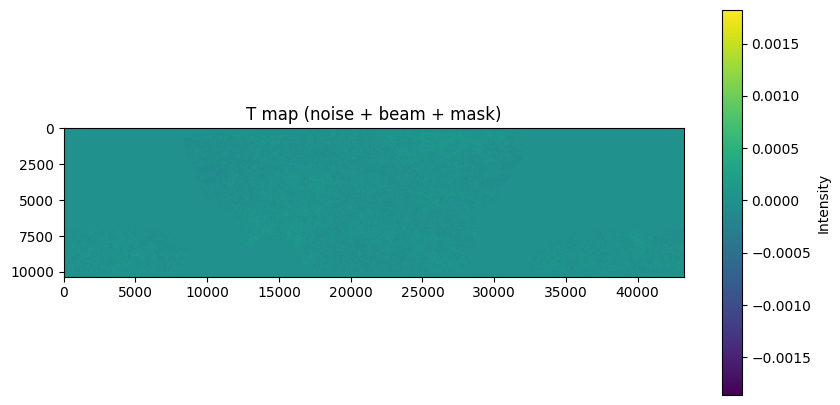

In [7]:
#############################
plt.figure(figsize=(10, 5))
plt.imshow(np.array(totmap_dict[af][0].data))#, grid=False)
plt.title('T map (noise + beam + mask)')
plt.colorbar(label='Intensity')
plt.show()

# downgrade


NOISE


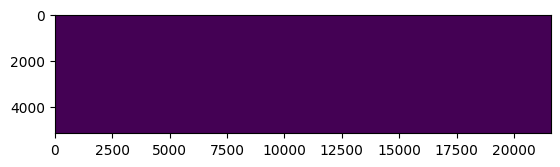

signal


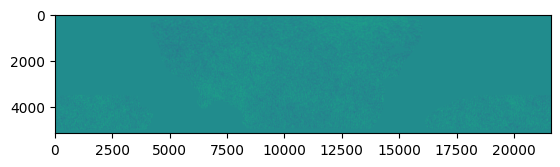

noise


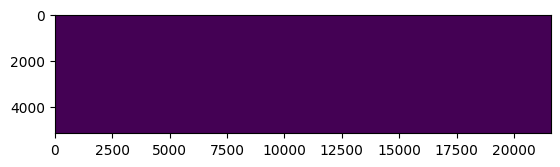

signal


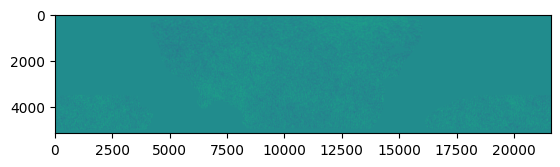


NOISE


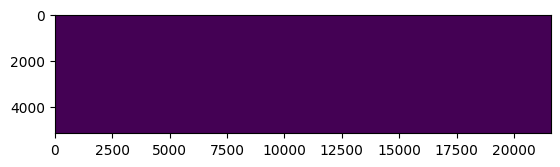

signal


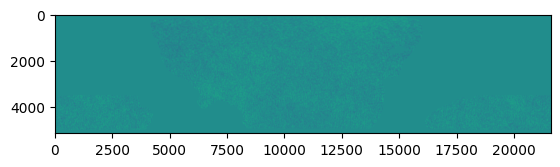

noise


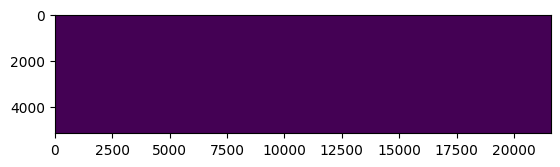

signal


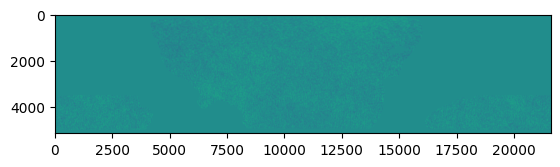


NOISE


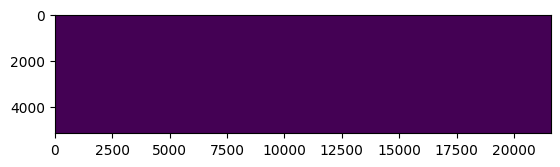

signal


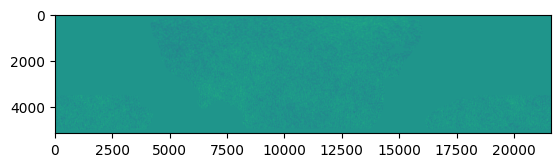

noise


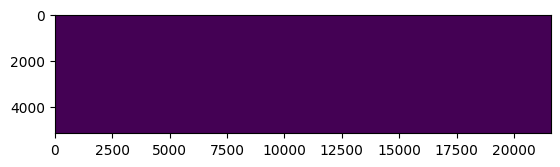

signal


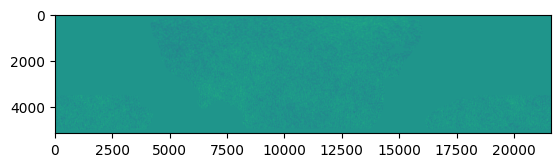


NOISE


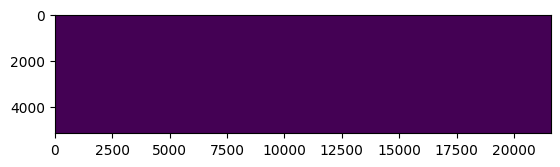

signal


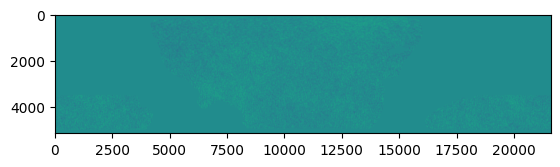

noise


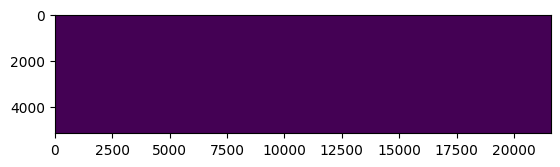

signal


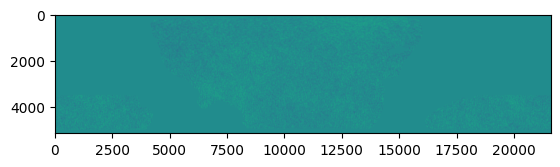


NOISE


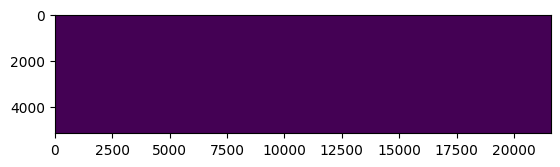

signal


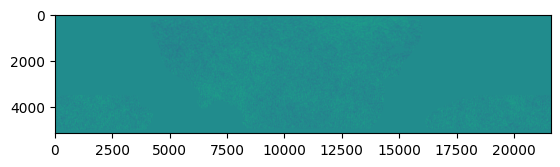

noise


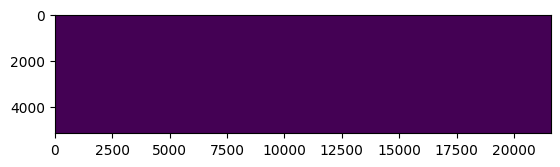

signal


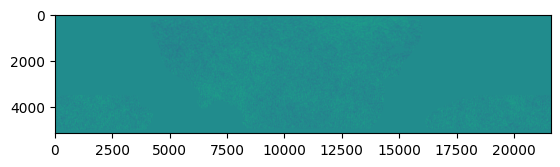

In [8]:
calibrated = True

for qid in qids:
    print ('')
    # get frequencies --------
    array_freq = array_dict[qid]
    array = array_freq[:3]
    freq = array_freq[4:]
    
    
    # NOISE MAPS --------------------
    stack = []
    for sset in np.arange(nsplits):
        ivarfn = re.sub("_map", "_ivar", data_maps_fn_pattern) % (array, freq, sim_num,split)
        mul = 1. / gain_dict[array_dict[qid]] if calibrated else 1.
        omap = enmap.read_map(outdir+ivarfn) * mul
        stack.append(omap)
    smap = enmap.enmap(np.stack(stack), omap.wcs)
    smap_downgraded = enmap.downgrade(smap, 2, op = np.sum)
    enmap.write_map(outdir+'/map_downgraded_ivar_{0}_{1}_{2}'.format(array,freq,sim_num), smap_downgraded)
        
    print ('NOISE')
    plt.imshow(smap_downgraded[0,0,:,:])
    plt.show()
    
    # DATA + NOISE MAPS ------------
    stack = []
    for sset in np.arange(nsplits):
        ivarfn = re.sub("_map", "_map_srcfree", data_maps_fn_pattern) % (array, freq, sim_num,split)
        mul = 1. / gain_dict[array_dict[qid]] if calibrated else 1.
        omap = enmap.read_map(outdir+ivarfn) * mul
        stack.append(omap)
    smap = enmap.enmap(np.stack(stack), omap.wcs)
    smap_downgraded = enmap.downgrade(smap, 2, op = np.sum)
    enmap.write_map(outdir+'/map_downgraded_srcfree_{0}_{1}_{2}'.format(array,freq,sim_num), smap_downgraded)
          
    print ('signal')
    plt.imshow(smap_downgraded[0,0,:,:])   
    plt.show()
    
    # coadd ----------------------------------
    ivarfn = re.sub("set%s_map", "coadd_ivar", data_maps_fn_pattern) % (array, freq, sim_num)
    mul = 1. / gain_dict[array_dict[qid]] if calibrated else 1.
    omap = enmap.read_map(outdir+ivarfn) * mul
    smap_downgraded = enmap.downgrade(omap, 2, op = np.sum)
    enmap.write_map(outdir+'/map_downgraded_coadd_ivar_{0}_{1}_{2}'.format(array,freq,sim_num), smap_downgraded)
    
    
    print ('noise')
    plt.imshow(smap_downgraded[0,:,:])  
    plt.show()
    
    ivarfn = re.sub("set%s_map", "coadd_map_srcfree", data_maps_fn_pattern) % (array, freq, sim_num)
    mul = 1. / gain_dict[array_dict[qid]] if calibrated else 1.
    omap = enmap.read_map(outdir+ivarfn) * mul
    smap_downgraded = enmap.downgrade(omap, 2, op = np.sum)
    enmap.write_map(outdir+'/map_downgraded_coadd_srcfree_{0}_{1}_{2}'.format(array,freq,sim_num), smap_downgraded)
    
    print ('signal')
    plt.imshow(smap_downgraded[0,:,:])  
    plt.show()

# inpaint

In [9]:
mask_path = path_files + "/mask/act_mask_fejer1_20220316_GAL070_rms_70.00_downgrade_3dg.fits"
mask = enmap.read_map(mask_path)
shape, wcs = mask.shape, mask.wcs

lras,ldecs = np.loadtxt(catalog_large,unpack=True,delimiter=',')
rras,rdecs = np.loadtxt(catalog_regular,unpack=True,delimiter=',')
lcoords = np.asarray((ldecs,lras))
rcoords = np.asarray((rdecs,rras))
lrad = 10.0
rrad = 6.0
mask1 = maps.mask_srcs(shape,wcs,lcoords,lrad)
mask2 = maps.mask_srcs(shape,wcs,rcoords,rrad)

jmask = mask1 & mask2
jmask = ~jmask




In [10]:
for qid in qids:
    # get frequencies --------
    array_freq = array_dict[qid]
    array = array_freq[:3]
    freq = array_freq[4:]
    
    # do it for the stacked maps ------------------------------------------------
    ivar_map = enmap.read_map(outdir+'/map_downgraded_ivar_{0}_{1}_{2}'.format(array,freq,sim_num))
    sig_map = enmap.read_map(outdir+'/map_downgraded_srcfree_{0}_{1}_{2}'.format(array,freq,sim_num))
    sig_map[...,mask<0.25]=0.0 ##intial maps had been masked (before downgrading) -- maybe delete here --- do we have to mask with new inpainting??
    ivar_map[...,mask<0.25]=0.0
    ip_map = gapfill_edge_conv_flat(sig_map, jmask,ivar=ivar_map) #make sure everything is getting inpainted
    ip_map[...,mask<0.25]=0.0
    enmap.write_map(outdir+'/map_downgraded_srcfree_inpainted_{0}_{1}_{2}'.format(array,freq,sim_num),ip_map)
    del ip_map
    del ivar_map
    gc.collect()
    
    # do it for the coadded maps -------------------------------------------------
    ivar_map = enmap.read_map(outdir+'/map_downgraded_coadd_ivar_{0}_{1}_{2}'.format(array,freq,sim_num))
    sig_map = enmap.read_map(outdir+'/map_downgraded_coadd_srcfree_{0}_{1}_{2}'.format(array,freq,sim_num))
    sig_map[...,mask<0.25]=0.0 ##intial maps had been masked (before downgrading) -- maybe delete here --- do we have to mask with new inpainting??
    ivar_map[...,mask<0.25]=0.0
    ip_map = gapfill_edge_conv_flat(sig_map, jmask,ivar=ivar_map) #make sure everything is getting inpainted
    ip_map[...,mask<0.25]=0.0
    enmap.write_map(outdir+'/map_downgraded_coadd_srcfree_inpainted_{0}_{1}_{2}'.format(array,freq,sim_num),ip_map)
    del ip_map
    del ivar_map
    gc.collect()

/global/homes/m/mgatti/.conda/envs/cmb_lensing_env/lib/python3.8/site-packages/CMB_lensing_SBI/cmb_lensing_sbi_pipe.py:91: RuntimeWarning: divide by zero encountered in divide
  return np.random.standard_normal(shape) / np.sqrt(div)
/global/homes/m/mgatti/.conda/envs/cmb_lensing_env/lib/python3.8/site-packages/CMB_lensing_SBI/cmb_lensing_sbi_pipe.py:91: RuntimeWarning: divide by zero encountered in divide
  return np.random.standard_normal(shape) / np.sqrt(div)
/global/homes/m/mgatti/.conda/envs/cmb_lensing_env/lib/python3.8/site-packages/CMB_lensing_SBI/cmb_lensing_sbi_pipe.py:91: RuntimeWarning: divide by zero encountered in divide
  return np.random.standard_normal(shape) / np.sqrt(div)
/global/homes/m/mgatti/.conda/envs/cmb_lensing_env/lib/python3.8/site-packages/CMB_lensing_SBI/cmb_lensing_sbi_pipe.py:91: RuntimeWarning: divide by zero encountered in divide
  return np.random.standard_normal(shape) / np.sqrt(div)
/global/homes/m/mgatti/.conda/envs/cmb_lensing_env/lib/python3.8/sit

# kspace_coadd


so for each channel, the code :
subtract tsz profiles (this only works for data, for sims is set to False)
for each noise split, it deconvolves the beam
it applies some mask in k-space (this part is not clear to me, why is this necessary?
it estimates the noise from the data itself (this is also not clear to me, why is this needed? )
it corects the alms by some calibration (also this is not clear to me, where can I find more details?)
it ends up with a coaddition

deconvolve beam and coadd

In [49]:
mask_path = path_files + "/mask/act_mask_fejer1_20220316_GAL070_rms_70.00_downgrade_3dg.fits"
mask = enmap.read_map(mask_path)


sz_nemo = {}
sz90=enmap.read_map(nemomodel_f090)
sz_nemo["f090"] = sz90
sz150=enmap.read_map(nemomodel_f150)
sz_nemo["f150"] = sz150


all_maps = []
all_ivars = []
beam_fns = []
specs = ['I','Q','U']
nspecs = len(specs)
nqids = len(qids)
nalms = get_nalms(lmax, lmax)
noise_specs = np.zeros((nspecs, nqids, lmax+1), dtype = np.float64)
coadded_alms_specs = np.zeros((nspecs, nqids, nalms), dtype=np.complex128)



for q,qid in enumerate(qids):
    
    # get frequenies
    array_freq = array_dict[qid]
    array = array_freq[:3]
    freq = array_freq[4:]
    

    # get beam function COADD -------------------------------
    fn = f"{beams_path}coadd_{array}_{freq}_night_beam_tform_jitter_cmb.txt"
    #fn = f"{self.beams_path}set{splitnum}_{array}_{freq}_night_beam_tform_jitter_cmb.txt"
    ls, bells = np.loadtxt(fn, unpack=True, usecols=[0, 1])
    bells = bells / bells[0]
    beam_q = interp1d(ls, bells, bounds_error=False, fill_value=0)
    beam_fns.append(beam_q)    
    
    
    
    # this load the stacked nsplits ----------------------
    map_splits = enmap.read_map(outdir+'/map_downgraded_srcfree_inpainted_{0}_{1}_{2}'.format(array,freq,sim_num))
    ivar_splits = enmap.read_map(outdir+'/map_downgraded_ivar_{0}_{1}_{2}'.format(array,freq,sim_num))

    
        
    # get SZ BEAM --------------------------------------------------
    this_beam = szbeam150 if freq == "f150" else szbeam90
    ls, bells = np.loadtxt(this_beam, unpack=True, usecols=[0, 1])
    bells = bells / bells[0]
    sz_beam =  interp1d(ls, bells, bounds_error=False, fill_value=0)

    # subtract the foreground map ----------------------------------
    if model_subtract_tsz:
        foreground = reconvolve_maps(sz_nemo[freq],mask,sz_beam,beam_q)
        for j in range(len(map_splits)):
            map_splits[j][0] = map_splits[j][0] - foreground #only subtract foreground from T map

        
    all_maps.append(map_splits)
    all_ivars.append(ivar_splits)
    dec_maps = [] #deconvolved beam, pixell window and kspace filter
    dec_ivars = [] #assoc ivars of decon maps (ivars are not deconvolved)

    
    
    # deconvolve beam ----------------------------------------------
    for sp in range(nsplits):
        if data_run:
            fn = f"{beams_path}set{sp}_{array}_{freq}_night_beam_tform_jitter_cmb.txt"
            ls, bells = np.loadtxt(fn, unpack=True, usecols=[0, 1])
            bells = bells / bells[0]
            this_beam = interp1d(ls, bells, bounds_error=False, fill_value=0)
            smap = deconvolve_maps(map_splits[sp],mask,this_beam,lmax=6000)
        else:
            alm = cs.map2alm(map_splits[sp],lmax=6000)
            alm_decon = cs.almxfl(alm,lambda ell:1/gauss_beam(ell,beam_fwhm))
            imap = enmap.empty((3,)+mask.shape,mask.wcs,dtype=np.float32)
            smap = cs.alm2map(alm_decon,imap)
        dmap = kspace_mask(smap,vk_mask=[-1*90,90], hk_mask=[-1*50,50],deconvolve=True)
        
        
        # apply some mask in k-space (why?) --------------------------------
        k_mask=mask_kspace(imap.shape,imap.wcs,lxcut=90,lycut=50)
        maps.filter_map(imap,k_mask)

        dec_maps.append(dmap)
        dec_ivars.append(ivar_splits[sp])
        
    # estimate data noise --------------------------------
    bls=interp1d(np.arange(lmax),np.ones(lmax),bounds_error=False,fill_value=0)
    for ispec,spec in enumerate(specs):
        noisecl= get_datanoise(dec_maps,dec_ivars, ispec, ispec, mask,bls,beam_deconvolve=False,N=1,lmax =lmax)
        bin_edges = np.linspace(2,len(noisecl),300).astype(int)
        cents,cls=bandedcls(noisecl,bin_edges)
        cls=maps.interp(cents,cls)(np.arange(len(noisecl)))
        noise_specs[ispec, q] = cls
        np.savetxt(outdir + '/1dweights_map_noise_{0}_{1}.txt'.format(qids[q],spec),cls)
        
        
    ells_cal, cal = np.loadtxt(f"{calibration%(array,freq)}",unpack=True)
    cal = np.interp(np.arange(lmax),ells_cal,cal)

    
    # not clear here what to do
    noise = dec_maps[nsplits-1]
    
    
    # coadd
    #dec_splits = dec_maps
    #imap = enmap.zeros(dec_splits[0].shape,wcs=dec_splits[0].wcs)
    #ivarreff = enmap.zeros(dec_ivars[0].shape,wcs=dec_ivars[0].wcs)
    #for j in range(len(dec_ivars)):
    #    imap += dec_ivars[j]*dec_splits[j]
    #    ivarreff += dec_ivars[j]
    #noise = imap/ivarreff
    
    noise[~np.isfinite(noise)] = 0
    alms=cs.map2alm(noise,lmax=lmax)
    almsTcal=cs.almxfl(alms[0],1/cal)
    almsQcal=alms[1]/pol_eff[qids[q]]
    almsUcal=alms[2]/pol_eff[qids[q]]
    coadded_alms_specs[0,q]=almsTcal
    coadded_alms_specs[1,q]=almsQcal
    coadded_alms_specs[2,q]=almsUcal

    
    
    
dummy_beam = np.ones(noise_specs[0].shape) # Map already beam-deconvolved
f_shape = all_maps[0][0][0].shape
f_wcs = all_maps[0][0][0].wcs

kcoadd_I = kspace_coadd(coadded_alms_specs[0], dummy_beam, noise_specs[0])
kcoadd_Q = kspace_coadd(coadded_alms_specs[1], dummy_beam, noise_specs[1])
kcoadd_U = kspace_coadd(coadded_alms_specs[2], dummy_beam, noise_specs[2])
kcoadd = cs.alm2map(np.array([kcoadd_I, kcoadd_Q, kcoadd_U]), enmap.empty((3,) + f_shape, f_wcs))
#imap = enmap.empty(f_shape,f_wcs)
#omap = cs.alm2map(kcoadd_I,imap)
#io.plot_img(omap,down=8,filename=f"{LC.kcoadd_path}kcoadd_I.png")
#enplot.write("/home/s/sievers/kaper/scratch/lenspipe/sim_run/kcoadd/kcoadd0",enplot.plot(kcoadd[0]))

#this doesn't work :()
#Ealm,Balm=simgen.pureEB(kcoadd[1],kcoadd[2],mask,returnMask=0,lmax=LMAX,isHealpix=False)
#a=cs.alm2map(np.array([kcoadd_I,Ealm,Balm]),enmap.empty((3,)+f_shape,f_wcs))
k_alms=cs.map2alm(kcoadd,lmax=lmax).astype('complex64')
#k_alms=k_alms.astype(np.complex128)  ##This breaks my code!!!!

if model_subtract_tsz:
    tszsub = True
else:
    tszsub = False
#if args.coadd:
#    coadd_type = "coadded"
#else:
coadd_type = 0 #f"{args.split}"


outfn = f"{outdir}{kcoadded_alms%(tszsub,coadd_type)}"
hp.write_alm(outfn,k_alms,overwrite=True)

print("DONE ------")


ignore warning: some ivars are 0 but we are taking this into account 
0
generating alms
0.3041277154737765
ignore warning: some ivars are 0 but we are taking this into account 
0
generating alms
0.3041277154737765
ignore warning: some ivars are 0 but we are taking this into account 
0
generating alms
0.3041277154737765
ignore warning: some ivars are 0 but we are taking this into account 
0
generating alms
0.3041277154737765
ignore warning: some ivars are 0 but we are taking this into account 
0
generating alms
0.3041277154737765
ignore warning: some ivars are 0 but we are taking this into account 
0
generating alms
0.3041277154737765
ignore warning: some ivars are 0 but we are taking this into account 
0
generating alms
0.3041277154737765
ignore warning: some ivars are 0 but we are taking this into account 
0
generating alms
0.3041277154737765
ignore warning: some ivars are 0 but we are taking this into account 
0
generating alms
0.3041277154737765
ignore warning: some ivars are 0 but 

/tmp/ipykernel_2030105/2205946572.py:9: RuntimeWarning: divide by zero encountered in divide
  denom = np.sum(lbeams**2 / noise,axis=0)
/tmp/ipykernel_2030105/2205946572.py:11: RuntimeWarning: divide by zero encountered in divide
  weighted_alms=hp.almxfl(map_alms[i],lbeams[i]/noise[i])


DONE ------


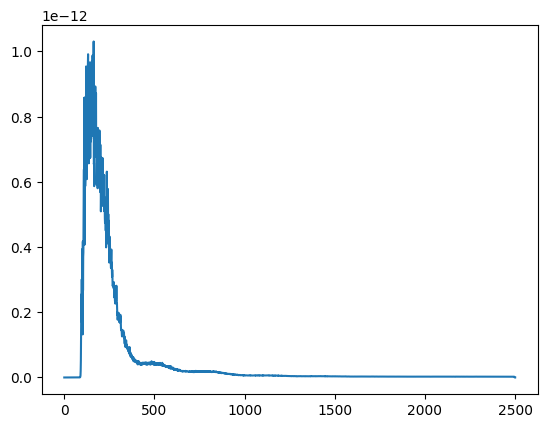

In [51]:
plt.plot(hp.alm2cl(k_alms[0].astype('complex128')))

In [ ]:
#!/bin/bash

#SBATCH --nodes=20
#SBATCH --time=23:59:59
#SBATCH --ntasks-per-node=2
#SBATCH --cpus-per-task=40
#SBATCH --job-name=lensing_pipe
#SBATCH -o /home/s/sievers/kaper/scratch/lenspipe/output_sh/lensing_pipe_full_%j.out
#SBATCH -e /home/s/sievers/kaper/scratch/lenspipe/output_sh/lensing_pipe_full_%j.err
#SBATCH --mail-type=ALL

source ~/.bashrc
export ENLIB_COMP=niagara_gcc

cd ~/gitreps/DR6plus_lensing/exploration/mock_pipe/

export DISABLE_MPI=false
export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK

qid='pa4av4 pa5av4 pa5bv4 pa6av4 pa6bv4'
fp=/home/s/sievers/kaper/gitreps/CMB_lensing_SBI/code/lensing_pipeline/filepaths.yaml

#------
#MAKING MOCK DATA ####
#mpirun -n 1 --bind-to none python make_mock_init.py

#-----
#preprocessing
#mpirun -n 1 --bind-to none python downgrade.py --filepath ${fp} --qid ${qid} --prepare_maps --prepare_ivars --coadd
#mpirun -n 1 --bind-to none python new_inpaint.py --filepath ${fp} --qid ${qid} --prepare_maps --coadd 
#mpirun -n 1 --bind-to none python kspace_coadd.py --filepath ${fp} --qid ${qid} --recalculate_weights --split 0 #--model_subtract

#----
#sim making
#mpirun -n 20 python make_sims_if.py --filepath ${fp} --set 0 --qid ${qid} --coadd 
#mpirun -n 20 python make_sims_if.py --filepath ${fp} --set 1 --qid ${qid} --coadd
#mpirun -n 20 python make_sims_mf_rdn0_n1.py --filepath ${fp} --set 0 
#mpirun -n 20 python make_sims_mf_rdn0_n1.py --filepath ${fp} --set 1
#mpirun -n 20 python make_sims_mf_rdn0_n1.py --filepath ${fp} --set 2 
#mpirun -n 20 python make_sims_mf_rdn0_n1.py --filepath ${fp} --set 3 

#----
#analysis
#mpirun -n 20 python filter.py --filepath ${fp}
#mpirun -n 1 --bind-to none python norms.py --filepath ${fp} --ph --bh --est1 MV
#mpirun -n 20 --bind-to none python mean_field.py --filepath ${fp} --ph --bh --est1 MV --set 0
#mpirun -n 20 --bind-to none python mean_field.py --filepath ${fp} --ph --bh --est1 MV --set 1
#mpirun -n 1 --bind-to none python auto.py --filepath ${fp} --ph --bh --est1 MV --nsets 2
#mpirun -n 1 --bind-to none python rdn0.py --filepath ${fp} --ph --bh --est1 MV --set 0
#mpirun -n 1 --bind-to none python rdn0.py --filepath ${fp} --ph --bh --est1 MV --set 1
#mpirun -n 1 --bind-to none python mcn1.py --filepath ${fp} --ph --bh --est MV 